##  Introduction
A time series is a series of data points indexed (or listed or graphed) in time order.Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values. ARIMA (autoregressive integrated moving average) model will be used to forecast the milk production for next year. A loop has been generated over the seasonal and non seasonal order of the model and then auto_arima function is used with proper hyperparameter tuning for forecasting. This model can be used to predict sale data ove the years that has seasonal components.

In [1]:
# importing necessary libararies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# time series analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Stationary
from statsmodels.tsa.arima.model import ARIMA#
from pandas.plotting import autocorrelation_plot
# model fiiitng
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

import pmdarima as pm
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error


### About working dataset

In [2]:
milk_production=pd.read_csv('G:\\datacamp\\Time Series\\ch-4 SARIM_AARIMA\\milk_production.csv',parse_dates=['date'],index_col='date')

In [3]:
milk_production.head(),milk_production.info(),milk_production.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pounds_per_cow  168 non-null    float64
dtypes: float64(1)
memory usage: 2.6 KB


(            pounds_per_cow
 date                      
 1962-01-01           589.0
 1962-02-01           561.0
 1962-03-01           640.0
 1962-04-01           656.0
 1962-05-01           727.0,
 None,
        pounds_per_cow
 count      168.000000
 mean       754.708333
 std        102.204524
 min        553.000000
 25%        677.750000
 50%        761.000000
 75%        824.500000
 max        969.000000)

### Visulaizing the dataset

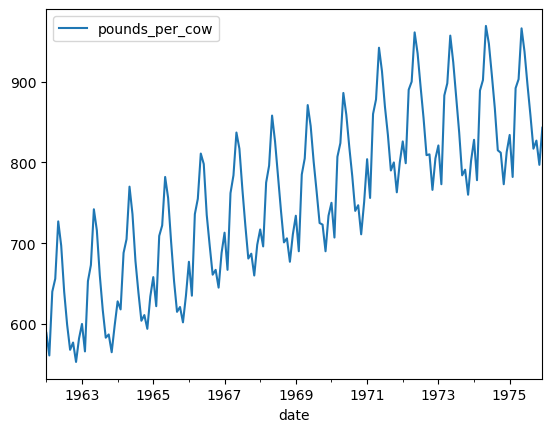

In [4]:
milk_production.plot()
plt.show()

### Data Distribution

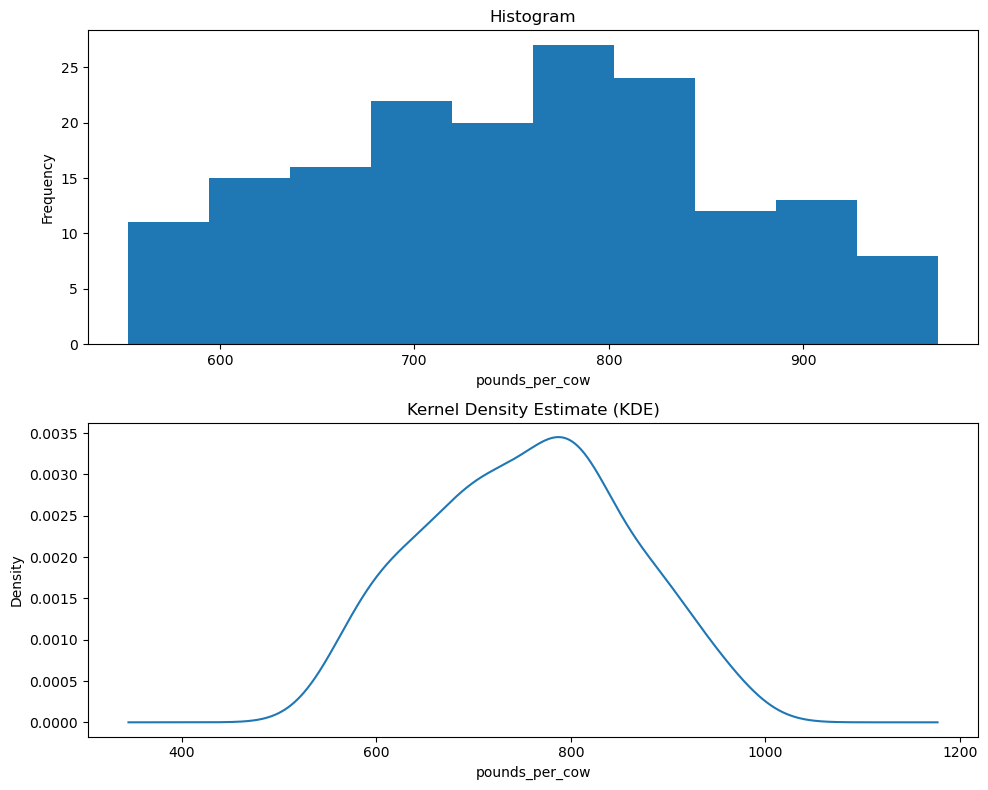

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
milk_production['pounds_per_cow'].plot(kind='hist', ax=axes[0], title='Histogram')
axes[0].set_xlabel('pounds_per_cow')
axes[0].set_ylabel('Frequency')

# KDE
milk_production['pounds_per_cow'].plot(kind='kde', ax=axes[1], title='Kernel Density Estimate (KDE)')
axes[1].set_xlabel('pounds_per_cow')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

The above plots provide a visual representation of the distribution of milk production in pounds per cow. The histogram reveals that most cows produce between 700 and 800 pounds of milk, with a noticeable decline in frequency as production exceeds 800 pounds. The Kernel Density Estimate (KDE) plot corroborates this observation, showcasing a peak density around the same range and tapering off for higher production values. These visualizations are instrumental in understanding the variability and distribution trends in milk production across different cows.

In [6]:
milk_production.columns

Index(['pounds_per_cow'], dtype='object')



### seasonal decompose and time series Visualization

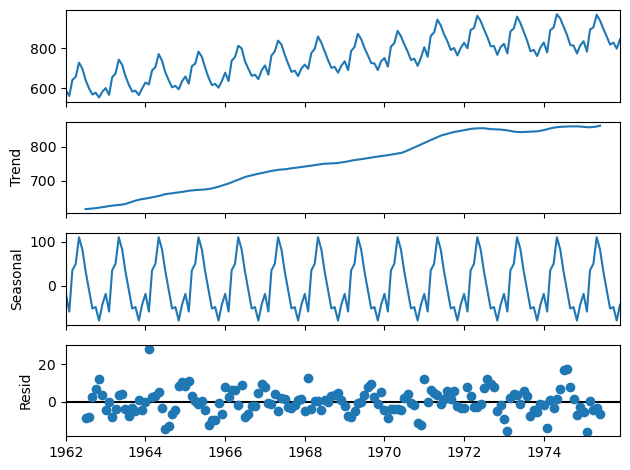

In [7]:
decomp = seasonal_decompose(milk_production, 
                            period=12)

# Plot decomposition
decomp.plot()
plt.show()

The plot shows the decomposition of a time series data using seasonal decompose. The decomposition separates the time series data into its trend, seasonal, and residual components. The trend component represents the long-term progression of the data, while the seasonal component depicts regular oscillations or cycles in the data that repeat over time. The residual component shows residuals which are random variations left after extracting trend and seasonality.

### Data smoothing for stationary analysis

In [8]:
# Data Smoothing for 1 year mean

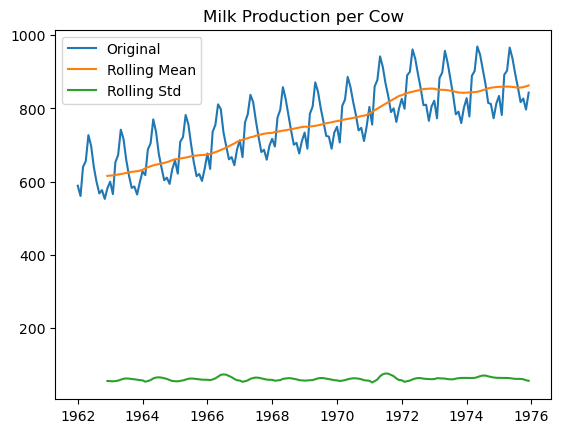

In [9]:
# Compute the rolling mean and standard deviation
rolling_mean = milk_production.rolling(window=12).mean() ## smoothing the data for
rolling_std = milk_production.rolling(window=12).std()

# Plot the data, rolling mean, and rolling standard deviation
import matplotlib.pyplot as plt
plt.plot(milk_production, label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend(loc='best')
plt.title('Milk Production per Cow')
plt.show()

we can see the trend of  one year mean rooling and the rolling standard of the data.

## Is the Data Stationary?
### adf_test
The Augmented Dickey-Fuller (ADF) test is a statistical test that checks for stationarity of a time series data in a statistical manner.  The null hypothesis of the test is that the time series data is non-stationary. The ADF statistic of **-1.3038**(less than 1% critical value) and the p-value of **0.6274** suggest that we cannot reject the null hypothesis at the 5% significance level. This means that the time series data is likely non-stationary .

In [10]:
def adf_check (time_series):
#This function calculate the adfuller test for a time series data***
    result = adfuller (time_series)
    print ('Augmented Dickey Fuller Test :')
    labels = ['ADF Test Statistics', 'P Value', 'Number of Lags Used','Number of Observations']
    for value, label in zip(result, labels):
        print (label +' : '+ str (value))
        
    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis so the null hypothesis is rejected. Thus data is stationary.")

    else:
        print("Weak evidence against null hypothesis so fail to reject the null hypothesis. Thus data is non stationary.")
      

In [11]:
adf_check(milk_production['pounds_per_cow'])


Augmented Dickey Fuller Test :
ADF Test Statistics : -1.3038115874221312
P Value : 0.6274267086030308
Number of Lags Used : 13
Number of Observations : 154
Weak evidence against null hypothesis so fail to reject the null hypothesis. Thus data is non stationary.


### acf and pacf
The plot shows the autocorrelation function (ACF) and partial autocorrelation function (PACF) of the ‘pounds_per_cow’ series from the ‘milk_production’ DataFrame. The ACF plot shows the correlation between the ‘pounds_per_cow’ series and its lagged values, while the PACF plot shows the correlation between the ‘pounds_per_cow’ series and its lagged values after removing the effect of intervening lags.

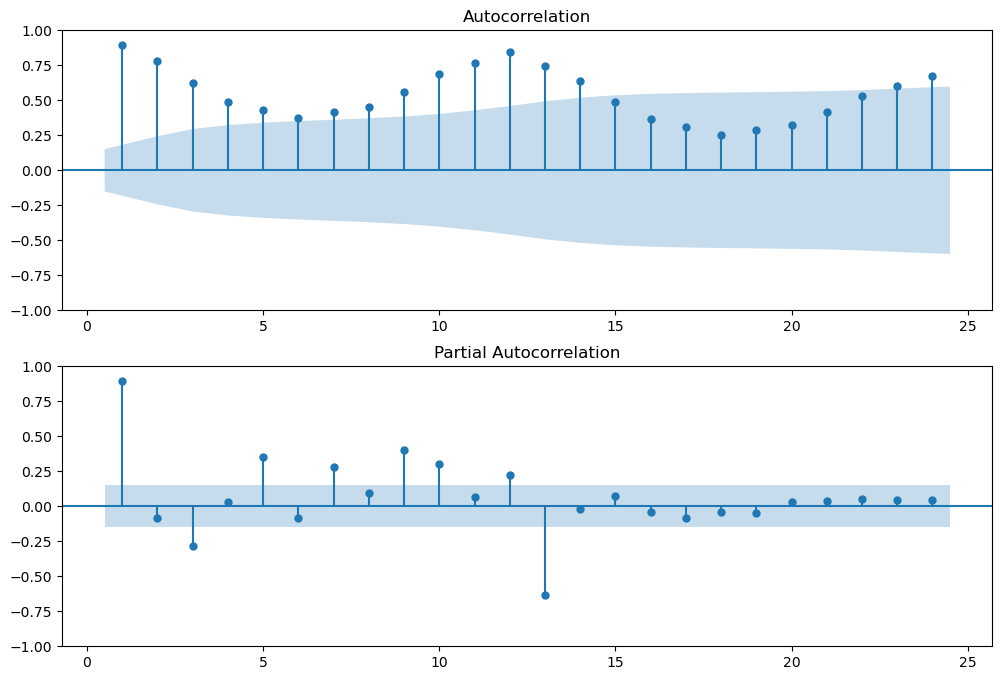

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(milk_production['pounds_per_cow'], lags=24, zero=False, ax=ax1)
plot_pacf(milk_production['pounds_per_cow'], lags=24, zero=False, ax=ax2)
plt.show()

The ACF (Autocorrelation Function) graph shows a gradual decline then increment, indicating a positive correlation between the time series data and its lags. It appears that seasonal pattern cycle repeats every 12 steps. The PACF (Partial Autocorrelation Function) graph has a significant spike at lag 1, suggesting that most of the autocorrelation can be explained by the direct relationship between each observation and its immediate predecessor. It also has negative spike at lag 3, and positive spikes at lag 5,7,8,10 and 12 suggest that there could be a seasonal correlation.

## Data Tranformation
Since the Time Series is Not Stationary, the dataset is transformed as a new DataFrame with First Differene and Seasonal First Difference to make it as a Stationary Serie

In [13]:
diff1 = milk_production.diff().diff(12).dropna()

In [14]:
adf_check(diff1['pounds_per_cow'])

Augmented Dickey Fuller Test :
ADF Test Statistics : -5.038002274921973
P Value : 1.865423431878921e-05
Number of Lags Used : 11
Number of Observations : 143
Strong evidence against null hypothesis so the null hypothesis is rejected. Thus data is stationary.


As we can see the data is stationary after tking the first differnce. We can also check the acf and pacf for a visual reprentation.

### Non seasonal Stationary check for trend analysis

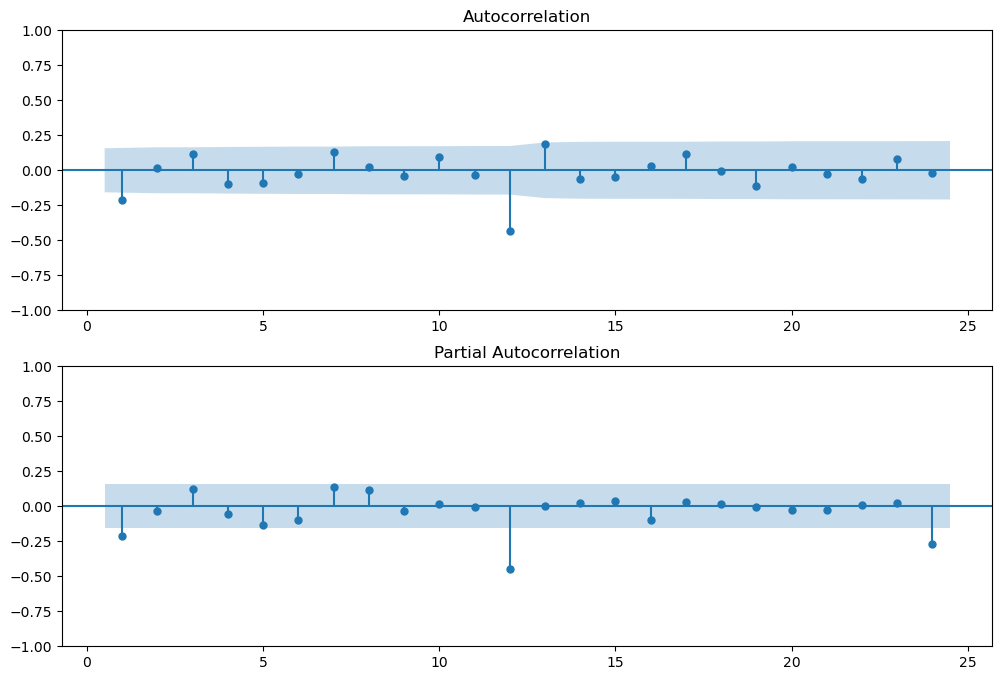

In [15]:

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot the ACF and PACF
plot_acf(diff1['pounds_per_cow'], lags=24, zero=False, ax=ax1)
plot_pacf(diff1['pounds_per_cow'], lags=24, zero=False, ax=ax2)
plt.show()

ACF and PACF plot suggest that there is a strong seasonal correlation. The negative spike observed at lag 12 suggest that there is a strong seasonal correlation<p>
We can now check if all the seasonal information has been captured by the diff or not. For this purpose, we need to take lag at seasonal point and check the acd and pacf plot.

### Seasonality check in Data for clarification

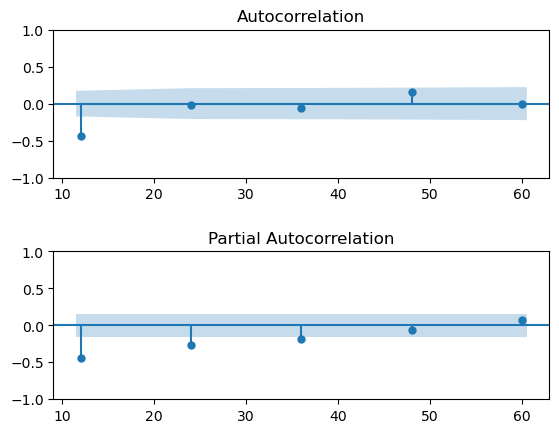

In [16]:
fig,(ax1,ax2)=plt.subplots(2,1)
plot_acf(diff1,lags=[12,24,36,48,60],ax=ax1)
plot_pacf(diff1,lags=[12,24,36,48,60],ax=ax2)
plt.subplots_adjust(hspace = 0.5)
plt.show()

So we can see thata fter taking the first transformation , the data can capture almost all the information. We can now fit our model. But first lets see the stationary and non stationary state of our data.

## Visualizing the stationary and non stationary state of the dataset


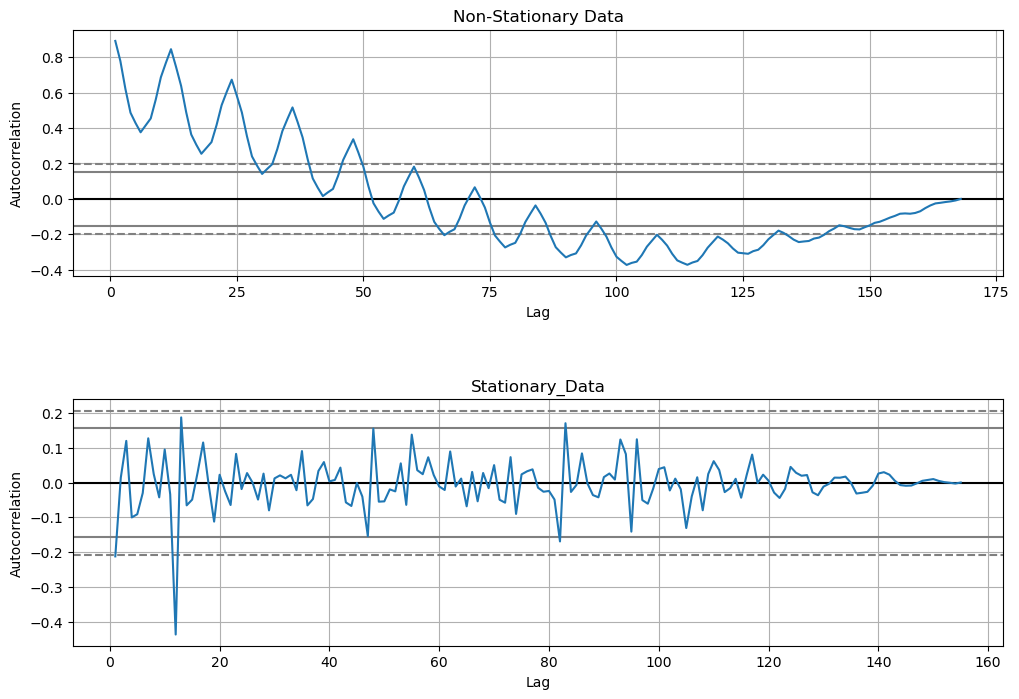

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (12,8))
ax1 = autocorrelation_plot(milk_production['pounds_per_cow'], ax = ax1)
ax1.set_title('Non-Stationary Data')
ax2 = autocorrelation_plot(diff1['pounds_per_cow'], ax = ax2)
ax2.set_title('Stationary_Data')
plt.subplots_adjust(hspace = 0.5)
#plt.savefig('Autocorrelation_plot of Stationary & Non-Stationary.png') # saving the fig in our local dir
plt.show()

the model need to be fitted before forecasting. We will use two models. At first we will code through to build our own model Then we will use the <code>auto_arima</code> package of python for forecasting.

## Model_fitting

This code is used for model selection in time series analysis, specifically for fitting a Seasonal Autoregressive Integrated Moving Average (SARIMA) model to a dataset representing monthly milk production. The purpose of the code is to systematically explore different combinations of model parameters and identify the model that minimizes the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC). These criteria are used to evaluate the goodness of fit of statistical models while penalizing for the number of parameters, thus helping to prevent overfitting.

In [18]:
milk_production.index.freq = 'MS' # selecting the index
# Define the range of values for p, d, q, P, D, Q, and s
p_values = range(5) 
d_values = [1]  # difference=1
q_values = range(5)
P_values = range(5)
D_values = [1]  #  difference=1
Q_values = range(5)
s_values = [12]  # monthly data

order_aic_bic = [] # to store results
# Loop over all combinations of p, d, q, P, D, Q, and s
for params in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    p, d, q, P, D, Q, s = params
    try:
        # Create and fit SARIMA model
        model = SARIMAX(milk_production['pounds_per_cow'], order=(p, d, q), seasonal_order=(P, D, Q, s),initialization='approximate_diffuse')
        results = model.fit(disp=False)
        
        # Append parameters and results tuple
        order_aic_bic.append((p, d, q, P, D, Q, s, results.aic, results.bic))
    except:
        continue

# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'd', 'q', 'P', 'D', 'Q', 's', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmod

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maxim

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:100

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:99

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.p

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\Lib\site-packages\st

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maxim

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: Convergenc

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespac

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:100

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maxim

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood op

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\Lib\site-pack

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\state

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\states

     p  d  q  P  D  Q   s          AIC          BIC
126  1  1  0  0  1  1  12  1285.099636  1294.471528
1    0  1  0  0  1  1  12  1285.222639  1291.470567
251  2  1  0  0  1  1  12  1286.975400  1299.471256
131  1  1  0  1  1  1  12  1287.099570  1299.595426
6    0  1  0  1  1  1  12  1287.184557  1296.556449
..  .. .. .. .. .. ..  ..          ...          ...
479  3  1  4  0  1  4  12  1641.868145  1679.355712
484  3  1  4  1  1  4  12  1642.489877  1683.101409
354  2  1  4  0  1  4  12  1642.928209  1677.291813
609  4  1  4  1  1  4  12  1644.489441  1688.224936
604  4  1  4  0  1  4  12  1646.600611  1687.212143

[625 rows x 9 columns]
     p  d  q  P  D  Q   s          AIC          BIC
1    0  1  0  0  1  1  12  1285.222639  1291.470567
126  1  1  0  0  1  1  12  1285.099636  1294.471528
6    0  1  0  1  1  1  12  1287.184557  1296.556449
26   0  1  1  0  1  1  12  1289.076110  1298.448002
251  2  1  0  0  1  1  12  1286.975400  1299.471256
..  .. .. .. .. .. ..  ..          ...  

The warning message "Maximum Likelihood optimization failed to converge. Check mle_retvals" indicates that the maximum likelihood optimization did not converge for some of the parameter combinations, and the optimization algorithm did not find a solution.

In [19]:
# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

     p  d  q  P  D  Q   s          AIC          BIC
126  1  1  0  0  1  1  12  1285.099636  1294.471528
1    0  1  0  0  1  1  12  1285.222639  1291.470567
251  2  1  0  0  1  1  12  1286.975400  1299.471256
131  1  1  0  1  1  1  12  1287.099570  1299.595426
6    0  1  0  1  1  1  12  1287.184557  1296.556449
..  .. .. .. .. .. ..  ..          ...          ...
479  3  1  4  0  1  4  12  1641.868145  1679.355712
484  3  1  4  1  1  4  12  1642.489877  1683.101409
354  2  1  4  0  1  4  12  1642.928209  1677.291813
609  4  1  4  1  1  4  12  1644.489441  1688.224936
604  4  1  4  0  1  4  12  1646.600611  1687.212143

[625 rows x 9 columns]
     p  d  q  P  D  Q   s          AIC          BIC
1    0  1  0  0  1  1  12  1285.222639  1291.470567
126  1  1  0  0  1  1  12  1285.099636  1294.471528
6    0  1  0  1  1  1  12  1287.184557  1296.556449
26   0  1  1  0  1  1  12  1289.076110  1298.448002
251  2  1  0  0  1  1  12  1286.975400  1299.471256
..  .. .. .. .. .. ..  ..          ...  

The code conducts a grid search to determine the optimal parameters for a Seasonal Autoregressive Integrated Moving Average (SARIMA) model applied to monthly milk production. The selection process is guided by the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC), with an emphasis on simplicity—favoring lower autoregressive and moving average orders. The identified top-performing model features a monthly seasonality (s=12) and is characterized by the configuration p=1, d=1, q=0, P=0, D=1, Q=1, s=12, resulting in the lowest AIC of approximately 1285.10. Additionally, an alternative model with parameters p=0, d=1, q=0, P=0, D=1, Q=1, s=12 achieves the lowest BIC at approximately 1291.47. This analysis facilitates the identification of a well-fitted SARIMA model for accurate predictions of monthly milk production patterns.

### Model 1 

In [35]:
# taking (p,d,q)=(0,1,0) and (P,D,Q)=(0,1,1)
model_1 = SARIMAX(milk_production['pounds_per_cow'], order=(0, 1, 0), seasonal_order=(0, 1, 1, 12))
model_1_results = model_1.fit(disp=False)
model_1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       pounds_per_cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -534.140
Date:                              Fri, 22 Dec 2023   AIC                           1072.280
Time:                                      00:14:01   BIC                           1078.367
Sample:                                  01-01-1962   HQIC                          1074.752
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.6110      0.066     -9.285      0.000      -0.740      -0.482
sigma2        55.5966      5.322     10.446      0.000      45.166      66.028
===================================================================================
Ljung-Box (L1) (Q):                   8.03   Jarque-Bera (JB):                31.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             0.78
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Log Likelihood:**
The log likelihood of -534.140 represents the maximized likelihood of observing the given data under the SARIMAX model. It serves as a measure of how well the model explains the observed data.<p>

**AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion):**
AIC (1072.280) and BIC (1078.367) are information criteria that balance goodness of fit with model complexity. Lower values indicate better-fitting models, with AIC and BIC penalizing for the number of parameters.<p>

**Coefficients:**
The coefficient for the seasonal moving average term (ma.S.L12) is -0.6110. This coefficient, along with its standard error, signifies the impact of the previous year's seasonal error on the current period's error.<p>

**Residual Variance (sigma2):**
The estimated variance of the residuals (sigma2) is 55.5966. It provides a measure of the variability in the unexplained portion of the data.<p>

**Ljung-Box Q Statistic:**
The Ljung-Box Q statistic of 8.03 tests for autocorrelation in the residuals at lag 1. A significant result suggests the presence of autocorrelation.<p>

**arque-Bera Test:**
The Jarque-Bera test of 31.77 assesses the normality of the residuals. A higher value indicates a departure from normality.<p>

**Heteroskedasticity (H):**
Heteroskedasticity (H = 0.70) measures the variability in the variance of residuals. A value close to 1 indicates homoskedasticity, while deviations from 1 suggest heteroskedasticity.<p>

**Skewness:**
Skewness of 0.78 indicates the asymmetry of the residuals' distribution. A positive skewness suggests a longer right tail.

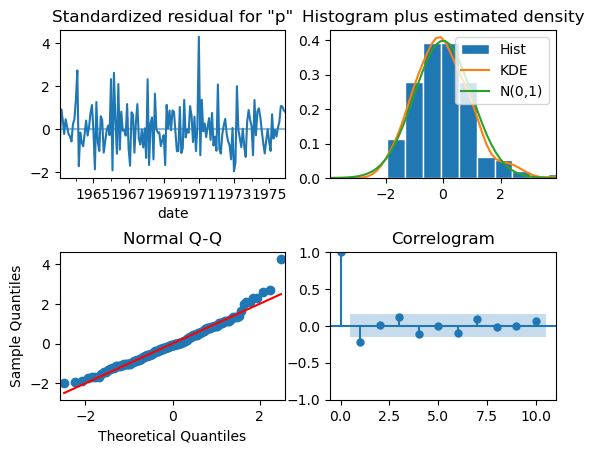

In [39]:
model_1_results.plot_diagnostics()
plt.subplots_adjust(hspace = 0.5)

plt.show()

We can also from the plot that resisuals are normally distributed and not autocorrelated. So we can say they are white noise and from the correlogram graph there is not nay correlation after first lag.

In [84]:
# Calculate the mean absolute error from residuals
mae_m1 = np.mean(np.abs(model_1_results.resid))
print('Mean Absolte Error for Model 1:',mae_m1)
mse_m1 = np.mean((model_1_results.resid)**2)
print("Mean Squared Error (MSE) for Model 1:", mse_m1)
rmse_m1 = np.sqrt(mse_m1)
print("Root Mean Squared Error (RMSE) for Model 1:", rmse_m1)

Mean Absolte Error for Model 1: 12.95248485458582
Mean Squared Error (MSE) for Model 1: 2695.3326116026346
Root Mean Squared Error (RMSE) for Model 1: 51.91659283507186


### Model_2

In [105]:
# taking (p,d,q)=(1,1,0) and (P,D,Q)=(0,1,1)
model_2 = SARIMAX(milk_production['pounds_per_cow'], order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
model_2_results = model_2.fit(disp=False)
model_2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       pounds_per_cow   No. Observations:                  168
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -530.104
Date:                              Fri, 22 Dec 2023   AIC                           1066.207
Time:                                      01:22:13   BIC                           1075.337
Sample:                                  01-01-1962   HQIC                          1069.916
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2253      0.077     -2.925      0.003      -0.376      -0.074
ma.S.L12      -0.6190      0.070     -8.825      0.000      -0.757      -0.482
sigma2        52.6908      4.897     10.759      0.000      43.093      62.289
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.11
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.74
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


**Log Likelihood:**
The log likelihood of -530.104 represents the maximized likelihood of observing the given data under the SARIMAX model, serving as an indicator of how effectively the model explains the observed data.<p>

**AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion):**
With AIC at 1066.207 and BIC at 1075.337, these information criteria strike a balance between goodness of fit and model complexity. Lower values signify better-fitting models, penalizing for the number of parameters.<p>

**Coefficients:**
The coefficient for the seasonal moving average term (ma.S.L12) is -0.6190, indicating the impact of the previous year's seasonal error on the current period's error. Its standard error is 0.070.<p>

**Residual Variance (sigma2):**
The estimated variance of the residuals (sigma2) stands at 52.6908, providing a measure of the variability in the unexplained portion of the data.<p>

**Ljung-Box Q Statistic:**
The Ljung-Box Q statistic of 0.01, along with a non-significant p-value of 0.91, suggests no significant autocorrelation in the residuals at lag 1.<p>

**Jarque-Bera Test:**
The Jarque-Bera test yields a value of 35.11 with a significant p-value of 0.00, indicating a departure from normality in the residuals.<p>
**Heteroskedasticity (H):**
Heteroskedasticity (H = 0.82) measures the variability in the variance of residuals. A value close to 1 indicates homoskedasticity, and in this case, a non-significant p-value of 0.49 suggests relatively constant variance in residuals.<p>

**Skewness:**
A skewness of 0.74 indicates the asymmetry of the residuals' distribution, with a slight positive skewness suggesting a longer right tail.

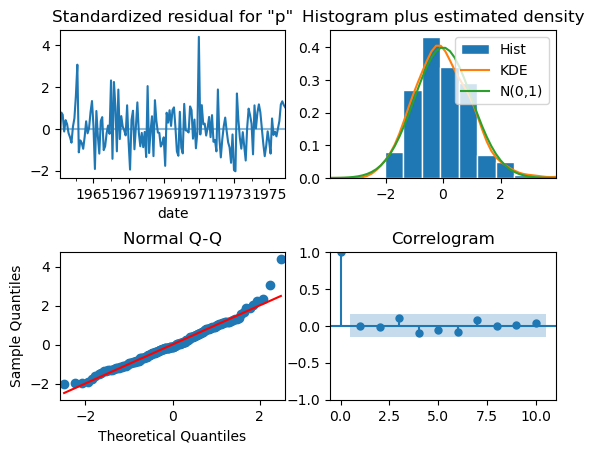

In [106]:
model_2_results.plot_diagnostics()
plt.subplots_adjust(hspace = 0.5)

plt.show()

We can also from the plot that resisuals are normally distributed and not autocorrelated. So we can say they are white noise and from the correlogram graph there is not nay correlation after first lag.

In [107]:
# Calculate the mean absolute error from residuals
mae_m2 = np.mean(np.abs(model_2_results.resid))
print('Mean Absolte Error:',mae_m2)
mse_m2 = np.mean((model_2_results.resid)**2)
print("Mean Squared Error (MSE):", mse_m2)
rmse_m2 = np.sqrt(mse_m2)
print("Root Mean Squared Error (RMSE):", rmse_m2)

Mean Absolte Error: 12.863538080785432
Mean Squared Error (MSE): 2692.7952568696687
Root Mean Squared Error (RMSE): 51.89215024326578


### Model_3
Here, we will use the <code>auto_arima</code> package of python

In [24]:
# selecting different hyperparameter for the analysis in auto_arima model

auto_arima_result = auto_arima(
    milk_production,
    d=1,
    start_p=1,
    start_q=1,
    max_p=5,
    max_q=5,
    seasonal=True,
    m=12,
    D=1,
    start_P=1,
    start_Q=1,
    max_P=5,
    max_Q=5,
    error_action='ignore',
    information_criterion='aic',
    stepwise=True
)
auto_arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -530.104
Date:                              Thu, 21 Dec 2023   AIC                           1066.207
Time:                                      22:31:12   BIC                           1075.337
Sample:                                  01-01-1962   HQIC                          1069.916
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2253      0.077     -2.925      0.003      -0.376      -0.074
ma.S.L12      -0.6190      0.070     -8.825      0.000      -0.757      -0.482
sigma2        52.6908      4.897     10.759      0.000      43.093      62.289
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.11
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.74
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

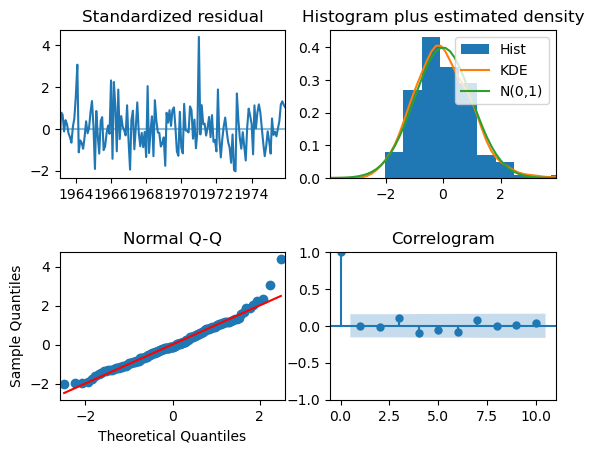

In [66]:
auto_arima_result.plot_diagnostics()
plt.subplots_adjust(hspace = 0.5)
plt.show()

So we can see residuals are white noise.

In [68]:
auto_arima_result

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

Evaluating the model with the result. we have split the data into train and test set for validation.

In [77]:

# selecting training and test data
train_data = milk_production['pounds_per_cow'].loc['1962-01-01':'1974-12-01']
test_data = milk_production['pounds_per_cow'].loc['1975-01-01':'1975-12-01']

# Make predictions on the auto_arima_result
predictions = auto_arima_result.predict(n_periods=len(test_data), return_conf_int=False)

# Calculate evaluation metrics
mae_m3 = mean_absolute_error(test_data, predictions)
mse_m3 = mean_squared_error(test_data, predictions)
rmse_m3= np.sqrt(mse)

# Print or use the results as needed
print('Mean Absolute Error (MAE) for Model 3:', mae_m3)
print('Mean Squared Error (MSE) for Model 3:', mse_m3)
print('Root Mean Squared Error (RMSE) for Model 3:', rmse_m3)

Mean Absolute Error (MAE) for Model 3: 31.082413667434555
Mean Squared Error (MSE) for Model 3: 1004.7991933225677
Root Mean Squared Error (RMSE) for Model 3: 31.698567685663143


In [100]:
mae_m2

12.95248485458582

In [108]:
mae_list = [mae_m1, mae_m2, mae_m3]
mse_list = [mse_m1, mse_m2, mse_m3]
rmse_list = [rmse_m1, rmse_m2, rmse_m3]
model_names = ['Model 1', 'Model 2', 'Model 3']

In [109]:
def store_errors(mae_list, mse_list, rmse_list, model_names):
    """
    This function takes in the MAE, MSE, and RMSE of different models and stores the results in a pandas dataframe.
    """
    # Create a dictionary to store the errors
    errors_dict = {'Model Name': model_names,
                   'MAE': mae_list,
                   'MSE': mse_list,
                   'RMSE': rmse_list}
    
    # Create a pandas dataframe from the dictionary
    errors_df = pd.DataFrame(errors_dict)
    return errors_df

In [110]:
errors_df = store_errors(mae_list, mse_list, rmse_list, model_names)
errors_df

,Model Name,MAE,MSE,RMSE
0,Model 1,12.952485,2695.332612,51.916593
1,Model 2,12.863538,2692.795257,51.892150
2,Model 3,31.082414,1004.799193,31.698568


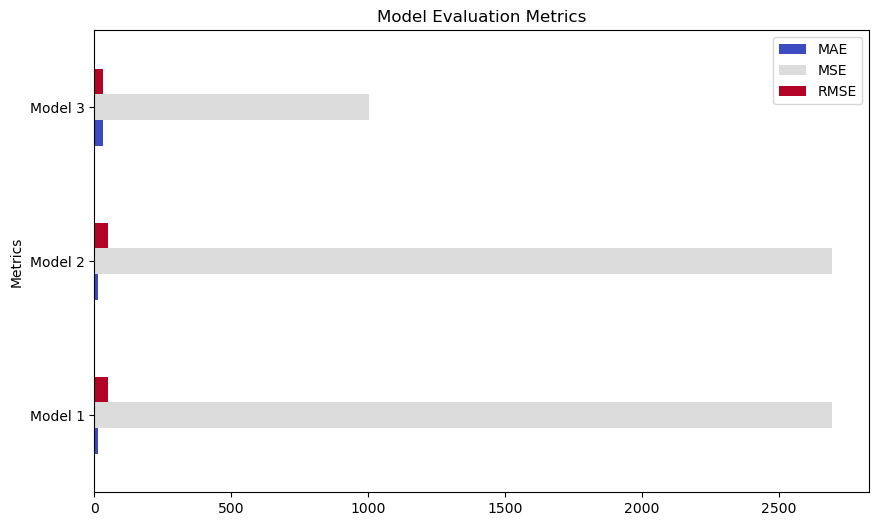

In [122]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot
errors_df.plot(kind='barh', x='Model Name', y=['MAE', 'MSE', 'RMSE'], ax=ax, colormap='coolwarm')

# Setting labels and title
ax.set_ylabel('Metrics')
ax.set_title('Model Evaluation Metrics')

# Display the plot
plt.show()

Though Model 1 and Model 2 giving same errors but the BIC of model 2 is slightly lower than the BIC of Model 1. MSE value for model 3 is much lower than the other two models. it has the order of (1,1,0)(0,1,1,12)

### Model Forecasting

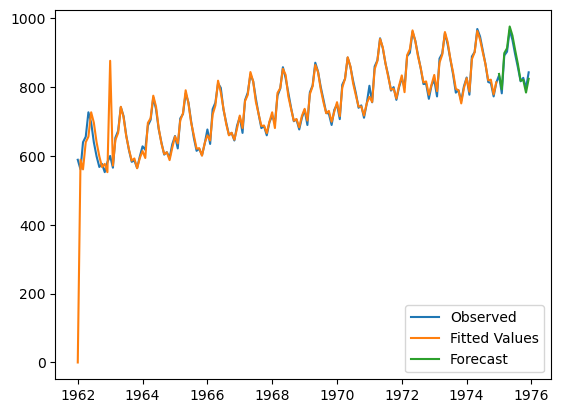

In [26]:
order = (1, 1, 0)
seasonal_order = (0, 1, 1, 12)

# selecting training and test data
train_data = milk_production['pounds_per_cow'].loc['1962-01-01':'1974-12-01']
test_data = milk_production['pounds_per_cow'].loc['1975-01-01':'1975-12-01']

# Fit SARIMA model to training data
sarima_model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit()

# Specify the number of steps to forecast
forecast_steps = len(test_data)
# forecast
forecast = sarima_results.get_forecast(steps=forecast_steps)

# Plot observed, fitted, and forecasted values
plt.plot(milk_production['pounds_per_cow'], label='Observed')
plt.plot(sarima_results.fittedvalues, label='Fitted Values')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.legend()
plt.show()

In [124]:
# Calculate and print RMSE
rmse = np.sqrt(((forecast.predicted_mean - test_data) ** 2).mean())
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Other evaluation metrics
mae = np.abs(forecast.predicted_mean - test_data).mean()
mape = np.mean(np.abs((test_data - forecast.predicted_mean) / test_data)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
#print(f"Forecast Values for 1975:",forecast.predicted_mean)
print(f"Forecast Values for 1975:\\n {forecast.predicted_mean}")



Root Mean Squared Error (RMSE): 10.710211263386537
Mean Absolute Error (MAE): 9.787630232935337
Mean Absolute Percentage Error (MAPE): 1.1348399316723579%
Forecast Values for 1975:\n 1975-01-01    838.322722
1975-02-01    793.824553
1975-03-01    898.706787
1975-04-01    912.980006
1975-05-01    976.257216
1975-06-01    949.855758
1975-07-01    908.369453
1975-08-01    867.773624
1975-09-01    818.723464
1975-10-01    820.846493
1975-11-01    784.252419
1975-12-01    824.263107
Freq: MS, Name: predicted_mean, dtype: float64


In [123]:
print(sarima_results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                       pounds_per_cow   No. Observations:                  156
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -491.265
Date:                              Fri, 22 Dec 2023   AIC                            988.530
Time:                                      01:41:17   BIC                            997.419
Sample:                                  01-01-1962   HQIC                           992.142
                                       - 12-01-1974                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2512      0.081     -3.093      0.002      -0.410      -0.092
ma.S.L12      -0.60

The coefficient analysis reveals interesting dynamics. The ar.L1 coefficient (-0.2253) suggests a negative impact of past values on current production, while the ma.S.L12 coefficient (-0.6190) highlights a significant seasonal effect, both contributing to the overall model dynamics.

Residual analysis of Model_2 indicates a slight departure from normality (JB = 35.11, p = 0.00), echoing the findings of the initial model. Furthermore, the Ljung-Box test (Q = 0.01, p = 0.91) suggests satisfactory independence of residuals.

But both model shows the order (1,1,0)(0,1,1,12). Comparing the models, we observe differences in key metrics and coefficients, emphasizing the importance of thorough analysis to select the most appropriate model for forecasting and understanding milk production trends.